In [1]:
from omegaconf import OmegaConf
import numpy as np
import os
import re
import os.path as osp
import torch
import pytorch_lightning as pl
from tqdm import tqdm
from omegaconf import OmegaConf
import wandb
from pytorch_lightning.loggers import WandbLogger

import model_factory
from graph_data_module import GraphDataModule
from train import Runner
from datasets.dataset_factory import create_dataset
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import torchvision
import torchmetrics
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
entity = "haraghi"
project = "DGCNN"

In [3]:
run_id = "di9222jw"
artifact_dir = WandbLogger.download_artifact(artifact=f"haraghi/DGCNN/model-{run_id}:best")

wandb:   1 of 1 files downloaded.  


In [4]:
method = "EST"
dataset = "NCARS"
specific_item = "MobileNet"

res = [f for f in os.listdir('cfg_folder') if method in f and dataset in f and specific_item in f]
for f in res:
    print(f)


EST_NCARS_no_aug_MobileNet_not_pretrained.yaml


In [5]:
api = wandb.Api()
if run_id is None:
    runs = api.runs(
        path=osp.join(entity,project),
        filters={"config.wandb.experiment_name": {"$regex": f"^.*{method}.*{sampling_number}.*$"}},
        # filters={"config.wandb.experiment_name": {"$regex": "^.*EST-aug 20000.*$"}}
    )
    print([l.id for l in runs])
    run_id = runs[0].id
    
print(run_id)

di9222jw


In [6]:
config = api.run(osp.join(entity, project, run_id)).config
cfg = OmegaConf.create(config)
cfg_file = OmegaConf.load(cfg.cfg_path)
# cfg = OmegaConf.merge(cfg_file, cfg)
# print(OmegaConf.to_yaml(cfg))

In [12]:
# run = wandb.init()
# checkpoint_reference = osp.join(entity, project, "model-" + run_id+":best")
# artifact = run.use_artifact(checkpoint_reference, type='model')
# artifact_dir = artifact.download()

In [7]:
def recursive_dict_compare(all_cfg, other_cfg):
    """
    Recursively compare two dictionaries and return their differences.
    """
    # Initialize the result dictionary
    diff = {}

    # Check for keys in dict1 that are not in dict2
    for key in other_cfg:
        if key not in all_cfg:
            diff[key] = other_cfg[key]
        else:
            # If the values are dictionaries, recursively compare them
            if isinstance(all_cfg[key], dict) and isinstance(other_cfg[key], dict):
                nested_diff = recursive_dict_compare(all_cfg[key], other_cfg[key])
                if nested_diff:
                    diff[key] = nested_diff
            # Otherwise, compare the values directly
            elif all_cfg[key] != other_cfg[key]:
                if not(key == "num_classes" and other_cfg[key] is None and all_cfg[key] is not None):
                    diff[key] = other_cfg[key]
                    

    return diff

# Example dictionaries
dict1 = {
    "name": "John",
    "age": 30,
    "address": {
        "street": "123 Main St",
        "city": "Anytown",
    },
}

dict2 = {
    "name": "Jane",
    "age": 30,
    "address": {
        "street": "456 Elm St",
        "city": "Othertown",
    },
}

# Compare the dictionaries recursively
differences = recursive_dict_compare(dict1, dict2)

# Print the differences
import pprint
# pprint.pprint(differences)


In [8]:
print(recursive_dict_compare(OmegaConf.to_object(cfg),OmegaConf.to_object(cfg_file)))

{}


In [9]:
def percentile(t, q):
    B, C, H, W = t.shape
    k = 1 + round(.01 * float(q) * (C * H * W - 1))
    result = t.view(B, -1).kthvalue(k).values
    return result[:,None,None,None]

def create_image(representation):
    B, C, H, W = representation.shape
    representation = representation.view(B, 3, C // 3, H, W).sum(2)

    # do robust min max norm
    representation = representation.detach().cpu()
    robust_max_vals = percentile(representation, 99)
    robust_min_vals = percentile(representation, 1)

    representation = (representation - robust_min_vals)/(robust_max_vals - robust_min_vals)
    representation = torch.clamp(255*representation, 0, 255).byte()

    representation = torchvision.utils.make_grid(representation)

    return representation

In [10]:
# Seed everything. Note that this does not make training entirely
# deterministic.
pl.seed_everything(cfg.seed, workers=True)


# Create datasets using factory pattern
gdm = GraphDataModule(cfg)
cfg.dataset.num_classes = gdm.num_classes

Global seed set to 0


In [ ]:
# test_file_list = []
# for data in gdm.test_dataloader():
#     test_file_list.extend(data.file_id)

In [ ]:
# train_file_list = []
# for data in gdm.train_dataloader():
#     train_file_list.extend(data.file_id)

In [ ]:
# val_file_list = []
# for data in gdm.val_dataloader():
#     val_file_list.extend(data.file_id)

In [ ]:
# print(len(train_file_list))
# print(len(test_file_list))
# print(len(val_file_list))

In [ ]:
# print(set(test_file_list).intersection(set(val_file_list)))
# print(set(test_file_list).intersection(set(train_file_list)))
# print(set(val_file_list).intersection(set(train_file_list)))

In [11]:
model = model_factory.factory(cfg)

# Tie it all together with PyTorch Lightning: Runner contains the model,
# optimizer, loss function and metrics; Trainer executes the
# training/validation loops and model checkpointing.
 
runner = Runner.load_from_checkpoint(osp.join(artifact_dir,"model.ckpt"), cfg=cfg, model=model)

In [12]:
trainer = pl.Trainer(
    max_epochs=cfg.train.epochs,
    enable_progress_bar=True,
    # Use DDP training by default, even for CPU training
    # strategy="ddp_notebook",
    devices=torch.cuda.device_count(),
    accelerator="auto"
)

/tudelft.net/staff-bulk/ewi/insy/VisionLab/maraghi/envs/gpu-env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tudelft.net/staff-bulk/ewi/insy/VisionLab/maraghi/e ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/tudelft.net/staff-bulk/ewi/insy/VisionLab/maraghi/envs/gpu-env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default log

In [13]:
trainer.test(runner, datamodule=gdm)

/tudelft.net/staff-bulk/ewi/insy/VisionLab/maraghi/envs/gpu-env/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /tudelft.net/staff-bulk/ewi/insy/VisionLab/maraghi/e ...
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 87/87 [00:52<00:00,  1.66it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test/acc            0.7698385119438171
        test/loss           1.5894675254821777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 1.5894675254821777, 'test/acc': 0.7698385119438171}]

In [14]:
dl = DataLoader(
            create_dataset(
                dataset_path = gdm.dataset_path,
                dataset_name  = gdm.dataset_name,
                dataset_type = 'test',
                transform = gdm.transform_dict['test'],
                num_workers=gdm.num_workers
            ),
            batch_size=16,
            shuffle=False,
            num_workers=gdm.num_workers,
        )
ds = create_dataset(
        dataset_path = gdm.dataset_path,
        dataset_name  = gdm.dataset_name,
        dataset_type = 'test',
        transform = gdm.transform_dict['test'],
        num_workers=gdm.num_workers
    )

In [25]:
torch.cuda.empty_cache()
confusion_matrix = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=cfg.dataset.num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = runner.model.to(device)
model.eval()

correct = 0
total = 0

y=torch.tensor([],device=device)
y_hat=torch.tensor([],device=device)
preds = []
targets = []
files = []
with torch.no_grad():
    for data in tqdm(gdm.test_dataloader()):
        files.extend(data.file_id)
        targets.append(data.y)
        data = data.to(device)
        y = torch.cat((y,data.y))
        out = model(data)
        preds.append(out.clone().detach().cpu())
        label = torch.argmax(out, dim=1) 
        y_hat = torch.cat((y_hat,label))
        correct += torch.sum(label == data.y)
        total += data.y.shape[0]
print(correct/total)   
y = y.clone().detach().cpu().numpy()
y_hat = y_hat.clone().detach().cpu().numpy() 

100%|██████████| 87/87 [00:31<00:00,  2.75it/s]

tensor(0.7698, device='cuda:0')


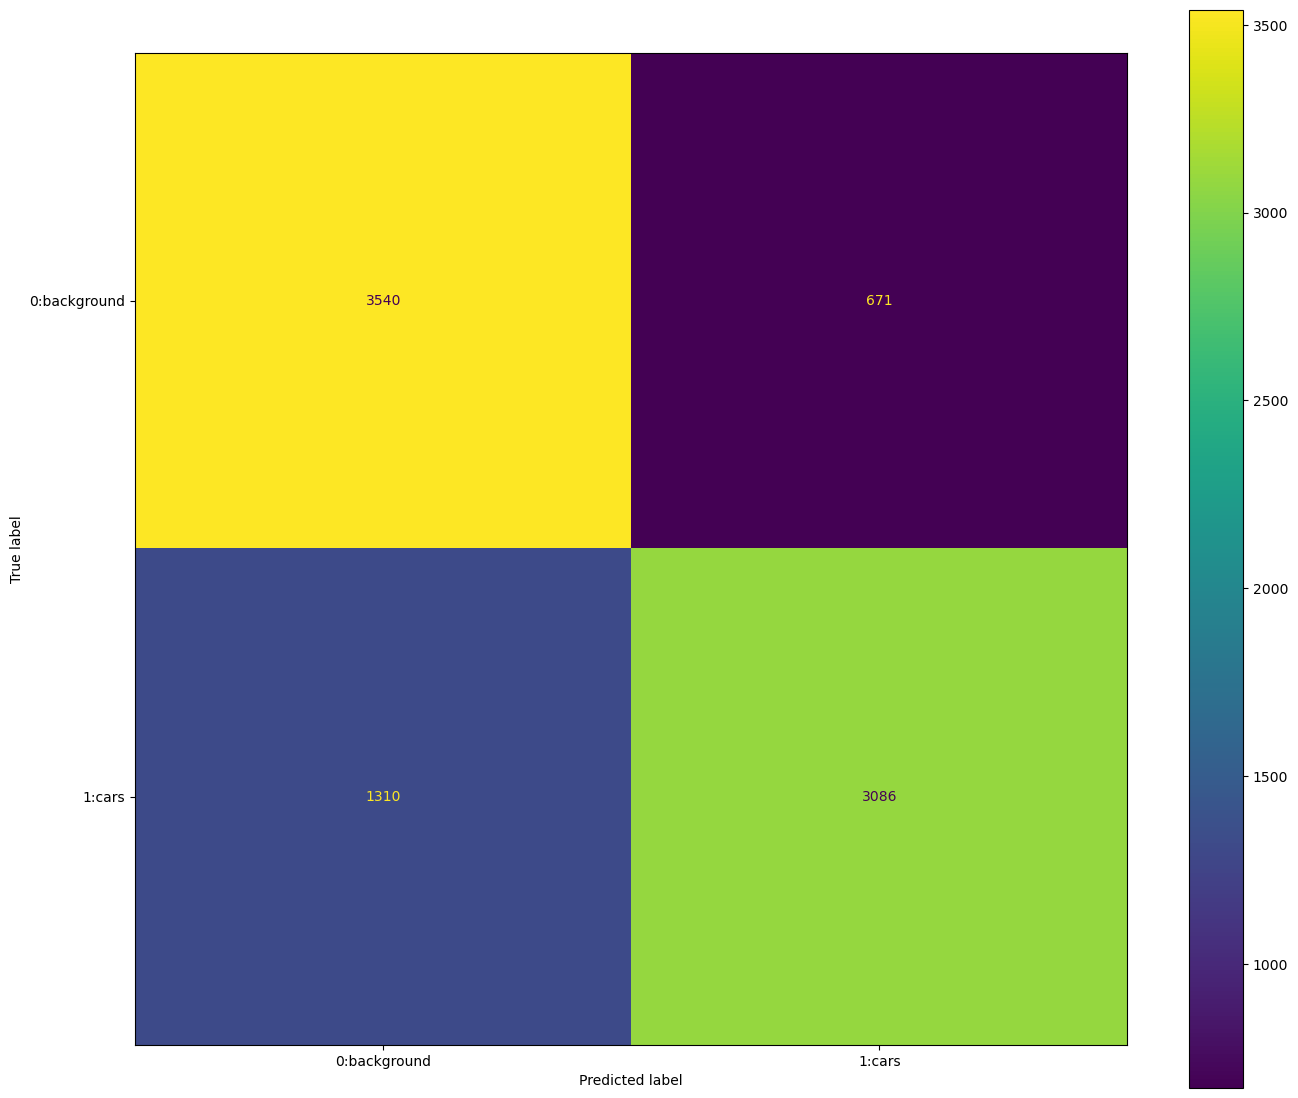

In [26]:
preds_ = torch.cat(preds,dim=0) #.permute(0,2,1)
targets_ = torch.cat(targets,dim=0)
metrics = torchmetrics.classification.MulticlassConfusionMatrix(num_classes=cfg.dataset.num_classes) 
metrics.update(preds_, targets_)
confusion_matrix_computed = metrics.compute().detach().cpu().numpy().astype(int)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_computed, display_labels = [f'{i}:{c}' for i,c in enumerate(ds.categories)])
fig, axs = plt.subplots(1, 1, figsize=(16,14))
disp.plot(ax=axs)
plt.show()

In [17]:
off_zero = confusion_matrix_computed - np.diag(np.diag(confusion_matrix_computed))
gg =  np.unravel_index(np.argsort(off_zero, axis=None), off_zero.shape)
for i in range(1, 20):
    print(f'The {i}th largest off-diagonal element is {off_zero[gg[0][-i], gg[1][-i]]} at ({gg[0][-i]}:{ds.categories[gg[0][-i]]} -> {gg[1][-i]}:{ds.categories[gg[1][-i]]})')

The 1th largest off-diagonal element is 1310 at (1:cars -> 0:background)
The 2th largest off-diagonal element is 671 at (0:background -> 1:cars)
The 3th largest off-diagonal element is 0 at (1:cars -> 1:cars)
The 4th largest off-diagonal element is 0 at (0:background -> 0:background)


IndexError: index -5 is out of bounds for axis 0 with size 4

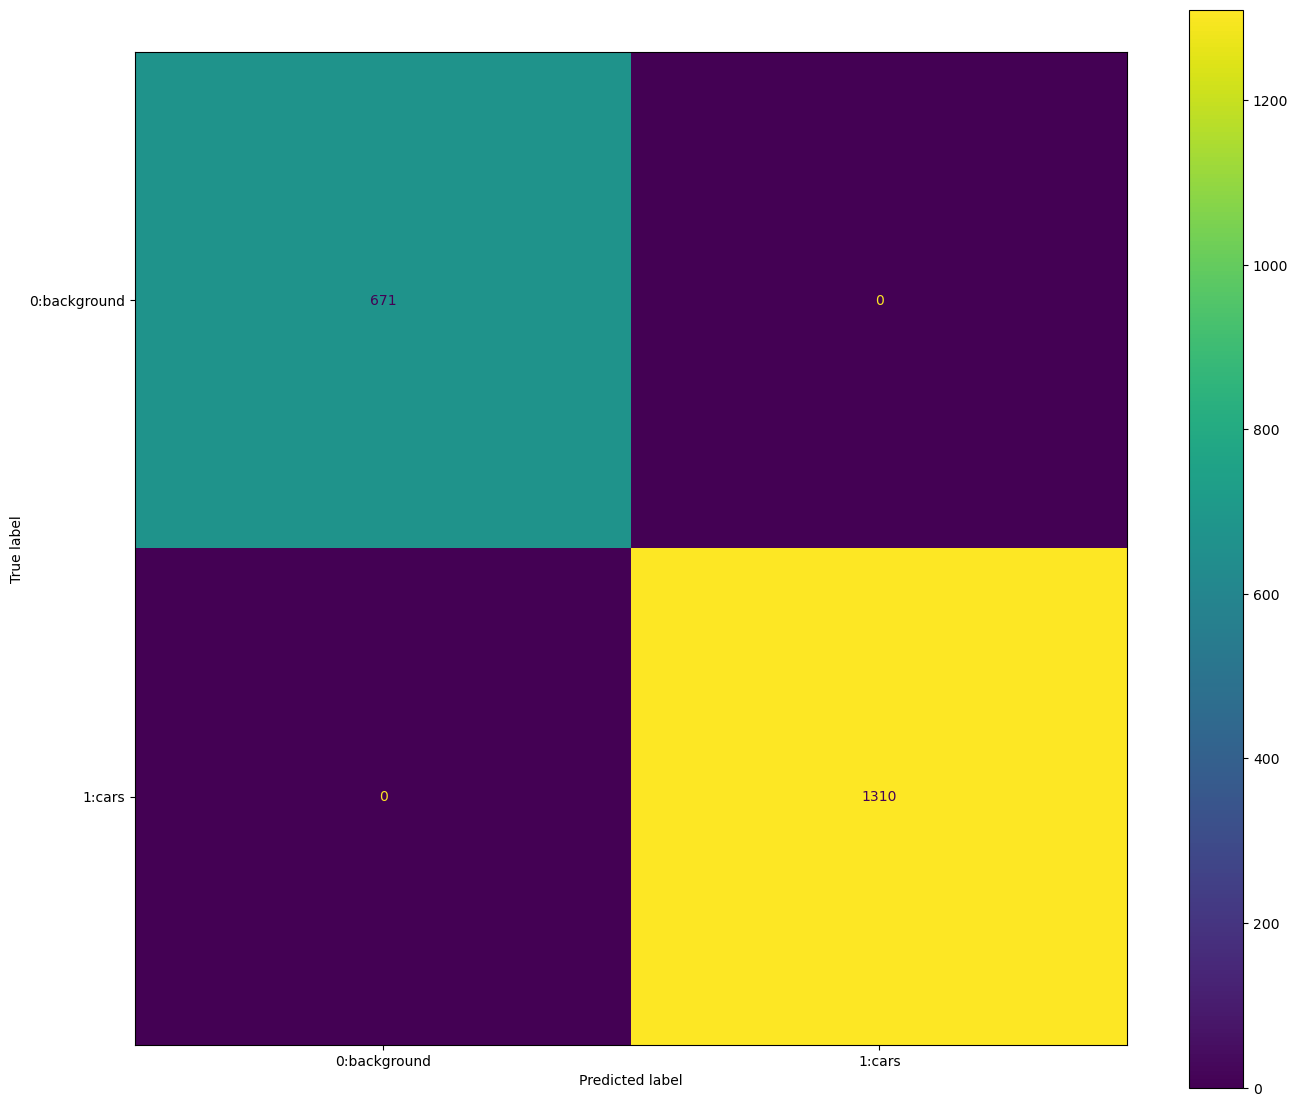

In [18]:
err_mat = np.diag(np.sum(off_zero,axis=1)) #+ np.diag(np.sum(off_zero,axis=0)) 
disp = ConfusionMatrixDisplay(confusion_matrix=err_mat, display_labels = [f'{i}:{c}' for i,c in enumerate(ds.categories)])
fig, axs = plt.subplots(1, 1, figsize=(16,14))
disp.plot(ax=axs)
plt.show()

In [27]:
for i in np.where((y == 1) & (y_hat == 0))[0]:
    print(i,ds[i].label,ds[i].file_id)

4212 ['cars'] obj_000560_td.dat
4214 ['cars'] obj_000544_td.dat
4216 ['cars'] obj_000493_td.dat
4217 ['cars'] obj_000484_td.dat
4219 ['cars'] obj_000363_td.dat
4220 ['cars'] obj_000360_td.dat
4226 ['cars'] obj_000246_td.dat
4228 ['cars'] obj_000147_td.dat
4240 ['cars'] obj_001045_td.dat
4242 ['cars'] obj_001018_td.dat
4245 ['cars'] obj_000835_td.dat
4246 ['cars'] obj_000808_td.dat
4247 ['cars'] obj_000796_td.dat
4248 ['cars'] obj_000793_td.dat
4254 ['cars'] obj_000711_td.dat
4260 ['cars'] obj_000587_td.dat
4267 ['cars'] obj_001573_td.dat
4271 ['cars'] obj_001549_td.dat
4278 ['cars'] obj_001342_td.dat
4282 ['cars'] obj_001265_td.dat
4285 ['cars'] obj_001210_td.dat
4288 ['cars'] obj_001173_td.dat
4290 ['cars'] obj_002264_td.dat
4291 ['cars'] obj_002257_td.dat
4292 ['cars'] obj_002243_td.dat
4295 ['cars'] obj_002223_td.dat
4297 ['cars'] obj_002193_td.dat
4298 ['cars'] obj_002146_td.dat
4303 ['cars'] obj_002043_td.dat
4305 ['cars'] obj_002039_td.dat
4313 ['cars'] obj_001890_td.dat
4315 ['c

In [20]:
name2ind = {d.file_id: i  for i, d in enumerate(ds)}

In [25]:
count = 0
for n,v in name2ind.items():
    if n.startswith('t_'):
        print(n, v)
        count += 1
        if count == 20:
            break

In [30]:
idx = torch.randint(0, len(ds),(1,))
idx = [6]
# idx = (name2ind['l_0011.mat'],)
correct = 0
total = 0

y1_hat = []
model.eval()

with torch.no_grad():
    for ii in tqdm(range(1000)):
        
        data = ds[idx][0]
        data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
        data = data.to(device)
        
        out = model(data)
        label = torch.argmax(out, dim=1)
        y1_hat.append(label.cpu().item())
        correct += torch.sum(label == data.y)
        total += data.y.shape[0]
    # loss = runner.loss_fn(y_hat, y)
print(data.file_id)  
print(data.label[0])
print(correct/total)
print([ds.categories[int(c)] for c in np.unique(np.array(y1_hat))])

100%|██████████| 1000/1000 [00:14<00:00, 70.73it/s]

obj_000379_td.dat
background
tensor(1., device='cuda:0')
['background']


In [31]:
ds[6]

Data(x=[5497, 1], pos=[5497, 3], file_id='obj_000379_td.dat', label=[1], y=[1])

In [27]:
np.where(np.array(y1_hat) !=  ds[idx][0].y.clone().detach().cpu().numpy())

(array([], dtype=int64),)

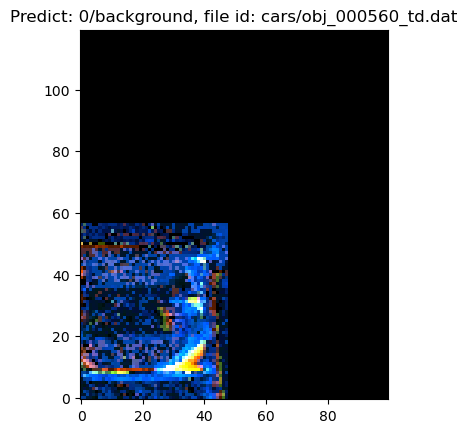

In [24]:

idx = 4212
data = ds[idx]

fig, axs = plt.subplots(1, 1)
data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
data = data.to(device)
out = model(data)
vox = model.quantization_layer.forward(data)
label = torch.argmax(out, dim=1)
rep = create_image(vox)
axs.imshow(rep.permute(1,2,0))
axs.invert_yaxis()
axs.set_title(f"Predict: {label.item()}/{ds.categories[label.item()]}, file id: {data.label[0]}/{data.file_id}")
plt.show()

In [ ]:

ys = [d.y.clone().detach().item() for d in ds]
ys = np.array(ys)

# count the number of happening of each value in the numpy array
unique, counts = np.unique(ys, return_counts=True)

print(counts)
print(counts.sum())

In [ ]:
n = 1
m = 2
with torch.no_grad():
    for u in unique:
        fig, axs = plt.subplots(n, m, figsize=(m*8,n*6))
        if n == 1:
            axs = axs[None,...]
        if m == 1:
            axs = axs[...,None]
        print(u)

        for i in range(n):
            for j in range(m):
                
                indices = np.where(ys == u)[0]
                idx = np.random.choice(indices)
                
                data = ds[idx]
                
                data.batch = torch.zeros(data.num_nodes, dtype=torch.long)
                data = data.to(device)
                out = model(data)
                vox = model.quantization_layer.forward(data)
                label = torch.argmax(out, dim=1)
                if label != u:
                    print("Wrong label")
                rep = create_image(vox)
                axs[i,j].imshow(rep.permute(1,2,0))
                # axs[i,j].invert_yaxis()
                axs[i,j].set_title(f"Predict: {label.item()}/{ds.categories[label.item()]}, file id: {data.label[0]}/{data.file_id}, idx: {idx}")

        plt.show()


In [ ]:
ds.categories[0]